In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
import multiprocessing as mul
from scipy import stats
import pickle
from scipy.integrate import quad
from corner import corner
import pandas as pd
from scipy.stats import gaussian_kde
import dynesty as dyn

In [17]:
grbparam = pd.read_csv(os.getcwd() + '/../data/GRBPARAM.csv', index_col=0)
grbname = 'GRB190114C.txt'
grb = 'GRB190114C'
arr = np.loadtxt(os.getcwd() + '/asciidataof_fig1/32lag/'+grbname)
data = [arr[:,0], arr[:,1], arr[:,2]]
x = arr[:,0]
y = arr[:,1]
yerr = arr[:,2]
lin_conv_fac = 3.0856 * 10**13
quad_conv_fac = 3.0856 * 10**7

#Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
H0= 6#7.36 * ((10**14) / 3.24 )
omega_m = 0.315
omega_l = 1 - omega_m




newe = pd.read_csv('2010.16029.txt', sep='\s+', header=None)
ncpu=12
E_newe = (newe[1].values + newe[0].values)/2.0
y_newe = newe[2].values
yerr_newe = newe[3].values


#MODELS


#NULL model
def nullhp(E, alpha, tau):
    return (1 + z_com)*(tau * ((E ** alpha) - (E0 ** alpha)))
    


def int_z(z_prime, n):
    integ_fn = lambda z: (1+z)**n / np.sqrt(omega_m * (1+z)**3 + omega_l)
    return quad( integ_fn, a=0, b=z_prime)[0]

int_z1 = np.asarray(int_z(z_com, 1))
int_z2 = np.asarray(int_z(z_com, 2))

#LINEAR model
def linearhp(E, logEqg, alpha, tau):
    
    e0qg = (E - E0) / (10 ** logEqg)
    
    return - (lin_conv_fac * e0qg * int_z1)/H0 + nullhp(E, alpha, tau)

#QUADRATIC model
def quadhp(E, logEqg, alpha, tau):
    e0qg = (E**2 - E0 **2) / ((10 ** logEqg)**2)
    
    return -1.5 * (lin_conv_fac * e0qg * int_z2)/H0 + nullhp(E, alpha, tau)


#LOG-LIKELIHOODS
def loglike_null(theta):
    alpha, tau = theta
    
    
    model = nullhp(x,  alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))
    
    

def loglike_linear(theta):
    logEqg, alpha, tau = theta
    
    model = linearhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))

def loglike_quad(theta):
    logEqg, alpha, tau = theta
    
    model = quadhp(x, logEqg, alpha, tau)
    
    return sum(stats.norm.logpdf(*args) for args in zip(y,model,yerr))


alphamin = -1
alphamax = 1
taumin = -10
taumax = 10
logeqmin = 6
logeqmax = 19


#PRIOR DISTRIBUTIONS

def prior_transform_null(theta):
    alpha, tau = theta
    return [(alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_linear(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]

def prior_transform_quadratic(theta):
    logEqg, alpha, tau = theta
    return [(logeqmax - logeqmin) * logEqg + logeqmin, (alphamax - alphamin) * alpha + alphamin, (taumax - taumin) * tau + taumin]


#SAMPLING
nlive = 1024

# Properties of GRB
E0 = grbparam[grbname.replace('.txt','')].E0
E0rest = E0
Erest = arr[:,0]    #in keV
z_com = grbparam[grbname.replace('.txt','')].redshift #redshift
threesamplers = ['_null_sampler.pkl', '_linear_sampler.pkl', '_quadratic_sampler.pkl']
sampler0 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[0])
sampler1 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[1])
sampler2 = dyn.utils.restore_sampler('./outputs/sampler_saves/' + grb + threesamplers[2])
results0 = sampler0.results
results1 = sampler1.results
results2 = sampler2.results

#PLOTTING FITS

nplot = 1000
E = np.linspace(min(Erest), max(Erest), nplot)
E_n = np.linspace(min(E_newe), max(E_newe), nplot)
samples0 = dyn.utils.resample_equal( results0.samples, np.exp(results0.logwt - results0.logz[-1]))
# samples0 = np.median(samples0, axis=0)
samples0 = samples0[np.argmax(results0.logl)]

samples1 = dyn.utils.resample_equal( results1.samples, np.exp(results1.logwt - results1.logz[-1]))
# samples1 = np.median(samples1, axis=0)
samples1 = samples1[np.argmax(results1.logl)]

samples2 = dyn.utils.resample_equal( results2.samples, np.exp(results2.logwt - results2.logz[-1]))
# samples2 = np.median(samples2, axis=0)
samples2 = samples2[np.argmax(results2.logl)]
null_fit = [nullhp(E[i], samples0[0], samples0[1]) for i in range(nplot)]
liv_lin_fit = [linearhp(E[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
liv_quad_fit = [quadhp(E[i], samples2[0], samples2[1], samples2[2]) for i in range(nplot)]

null_fit_newe = [nullhp(E_n[i], samples0[0], samples0[1],) for i in range(nplot)]
lin_fit_newe = [linearhp(E_n[i], samples1[0], samples1[1], samples1[2]) for i in range(nplot)]
quad_fit_newe = [quadhp(E_n[i], samples2[0], samples2[1], samples2[2]) for i in range(nplot)]

null2 = [nullhp(E_n[i], -0.84, 10.61) for i in range(nplot)]
lin2 = [linearhp(E_n[i], 14.49, -0.84, 10.61) for i in range(nplot)]
quad2 = [quadhp(E_n[i], 6, -1.21, 22.16) for i in range(nplot)]


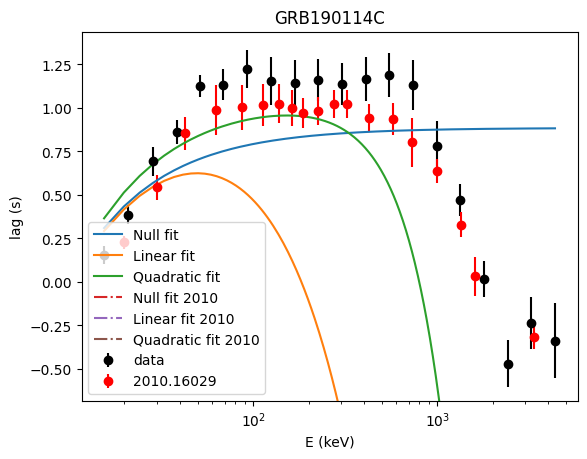

In [18]:
plt.figure()
plt.errorbar(Erest, y, yerr, fmt='o', color='black', label='data')
plt.errorbar(E_newe, y_newe, yerr_newe, fmt='o', color='red', label='2010.16029')
plt.plot(E, np.round(null_fit, 12), label='Null fit')
plt.plot(E, np.round(liv_lin_fit, 12),label='Linear fit')
plt.plot(E, np.round(liv_quad_fit, 12), label='Quadratic fit')
plt.plot(E_n, np.round(null2, 12), label='Null fit 2010', ls='-.')
plt.plot(E_n, np.round(lin2, 12),label='Linear fit 2010', ls='-.')
plt.plot(E_n, np.round(quad2, 12), label='Quadratic fit 2010', ls='-.')
# plt.plot(E_n, np.round(null_fit_newe, 12), label='Null fit 2010', ls='--')
# plt.plot(E_n, np.round(lin_fit_newe, 12),label='Linear fit 2010', ls='--')
# plt.plot(E_n, np.round(quad_fit_newe, 12), label='Quadratic fit 2010', ls='--')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(min(y) - max(abs(yerr)), max(y) + max(abs(yerr)))
# plt.ylim(0.25, 0.9)
# plt.ylim(-200, 20)
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grb)
plt.show()

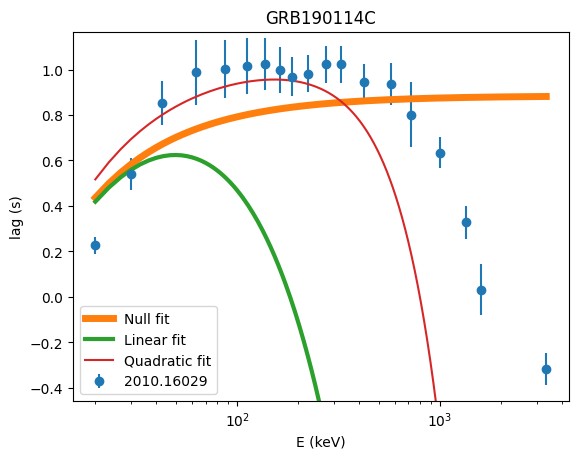

In [19]:
plt.figure()
plt.errorbar(E_newe, y_newe, yerr_newe, fmt='o', label='2010.16029')
plt.plot(E_n, np.round(null_fit_newe, 12), label='Null fit', lw=5)
plt.plot(E_n, np.round(lin_fit_newe, 12),label='Linear fit', lw=3)
plt.plot(E_n, np.round(quad_fit_newe, 12), label='Quadratic fit')
plt.xscale('log')
# plt.yscale('log')
plt.ylim(min(y_newe) - max(abs(yerr_newe)), max(y_newe) + max(abs(yerr_newe)))
# plt.ylim(-200, 20)
plt.legend()
plt.xlabel('E (keV)')
plt.ylabel('lag (s)')
plt.title(grb)
plt.show()

In [20]:
def chi2_gof(x, y, yerr, fit_func, *fit_func_args):
        
    return np.sum(((y - fit_func(x, *fit_func_args))/yerr)**2)/(len(y) - len(fit_func_args))


gof_null = chi2_gof(Erest, y, yerr, nullhp, samples0[0], samples0[1])
gof_lin = chi2_gof(Erest, y, yerr, linearhp, samples1[0], samples1[1], samples1[2])
gof_quad = chi2_gof(Erest, y, yerr, quadhp, samples2[0], samples2[1], samples2[2])
gof_null_newe = chi2_gof(E_newe, y_newe, yerr_newe, nullhp, samples0[0], samples0[1])
gof_lin_newe = chi2_gof(E_newe, y_newe, yerr_newe, linearhp, samples1[0], samples1[1], samples1[2])
gof_quad_newe = chi2_gof(E_newe, y_newe, yerr_newe, quadhp, samples2[0], samples2[1], samples2[2])

In [21]:
print('fit\t\t\t LIU GOF\t 2010.16029 GOF')
print('Null fit:\t', gof_null, '\t', gof_null_newe)
print('Lin fit:\t', gof_lin, '\t', gof_lin_newe)
print('Quadr fit:\t', gof_quad, '\t', gof_quad_newe)

fit			 LIU GOF	 2010.16029 GOF
Null fit:	 22.954401632538357 	 28.50546729709564
Lin fit:	 4575.124820597483 	 8484.469769549169
Quadr fit:	 2215.16967696558 	 3954.476204425291
